In [17]:
import pandas as pd
import warnings
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [18]:
df_industries = pd.read_excel('/Users/ju/Projects/00_SMU/mqf_practice/QF600_Asset_Pricing/Exam/data/Exam-Industry.xlsx', index_col='Date')
df_market = pd.read_excel('/Users/ju/Projects/00_SMU/mqf_practice/QF600_Asset_Pricing/Exam/data/Exam–Market.xlsx', index_col='Date')
df = pd.merge(df_industries, df_market, left_index=True, right_index=True)
# df_risk_factors = pd.read_excel('./data/Risk_Factors.xlsx', index_col='Date')

Hansen–Jagannathan Bound

Suppose that the representative investor has constant absolute risk aversion, which gives rise to the following pricing kernel:


Here b0 is the investor's coefficient of relative risk aversion, based on initial consumption.

Suppose that consumption growth has lognormal distribution with rare disasters:


Here ε is a standard normal random variable, while η is an independent random variable that represents the effect of rare disasters: η = ln(0.7) with probability of 2.4%, or zero otherwise.

Simulate the distribution for consumption growth with (at least) 104 random draws for ε and η. Calculate the volatility ratio of the pricing kernel, for b0 in the range from 0 to 5, in increments of 0.1 (or less). Plot the volatility ratio vs b0.

Find and report the smallest value of b0 for which the Hansen–Jagannathan bound is satisfied, in your data set.
State Prices

You must show all relevant working for these results.

Suppose that a one-period financial market has two states of nature: "good" and "bad".

This financial market has two assets: stock A and stock B. Both stocks have initial price of 70 (per share), and the following distribution of final payoffs (per share):

 	Good	Bad
Stock A	100	50
Stock B	80	65
Calculate the initial prices for the elementary Arrow–Debreu securities.

Calculate the risk-neutral probabilities for the two states.
Consider a financial derivative with final payoff given by Y = max[XA, XB] – 55, where XA and XB are the final payoffs for one share of stock A and stock B, respectively.

Calculate the initial price for this financial derivative.

Calculate the amount to invest in the two stocks, in order to replicate this financial derivative.

In [19]:
def estimate_pricing_kernel(size: int, p_nu: float, phi: float, gamma: float)-> tuple:
    """
    Estimates the pricing kernel statistics: mean, standard deviation, and ratio of std dev to mean.
    
    Parameters:
        size (int): Number of samples to generate.
        p_nu (float): Probability of shock occurrence (`nu`).
        phi (float): Scaling parameter for shock impact.
        gamma (float): Risk aversion parameter.

    Returns:
        mean_M (mean of pricing kernel), 
        sig_M (standard deviation of pricing kernel), 
        sig_M_over_mean_M (ratio of std dev to mean).
    """
    epsilon = np.random.standard_normal(size)
    nu = np.random.choice([1,0], size=size, p=[p_nu,1-p_nu]) * np.log(phi)


    ln_g = .02 + .02 * epsilon + nu
    est_M = 0.99*np.power(np.exp(ln_g),-gamma)

    mean_M = np.mean(est_M)
    sig_M = np.std(est_M)
    sig_M_over_mean_M = sig_M / mean_M

    return mean_M, sig_M, sig_M_over_mean_M

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_25253/3568191266.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


The smallest value of gamma for which sig_M/mu_M > 0.4 is: 3.6165413533834583


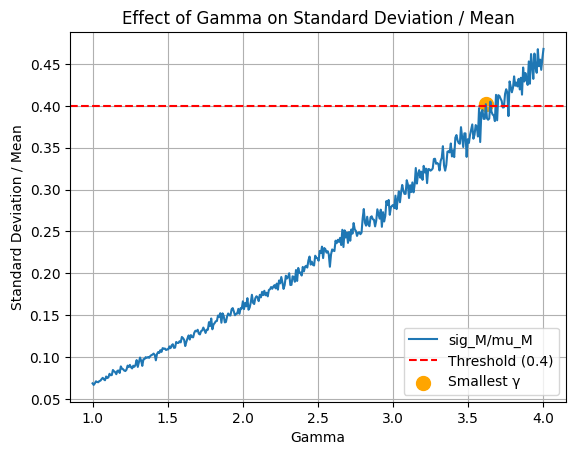

In [20]:
size        = 10**4
p_nu        = .024
phi         = .7
arr_gamma   = np.linspace(1,4,400)

# Generate results for gamma values from 1 to 4
results_df = pd.DataFrame(columns=['Gamma', 'Mean_M', 'Sig_M', 'Sig_M_over_Mean_M'])

for gamma in arr_gamma:
    mean_M, sig_M, sig_M_over_mean_M = estimate_pricing_kernel(size, p_nu, phi, gamma)
    # Create a temporary DataFrame for the current result
    temp_df = pd.DataFrame({
        'Gamma': [gamma],
        'Mean_M': [mean_M],
        'Sig_M': [sig_M],
        'Sig_M_over_Mean_M': [sig_M_over_mean_M]
    })
    # Concatenate the temporary DataFrame to results_df
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Find the smallest gamma where Sig_M_over_Mean_M > 0.4
threshold = 0.4
condition_met = results_df[results_df['Sig_M_over_Mean_M'] > threshold]
smallest_gamma = condition_met['Gamma'].iloc[0] if not condition_met.empty else None

# Display the smallest gamma
print(f"The smallest value of gamma for which sig_M/mu_M > 0.4 is: {smallest_gamma}")

# Plotting the last output against gamma
plt.plot(results_df['Gamma'], results_df['Sig_M_over_Mean_M'], label='sig_M/mu_M')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (0.4)')
if smallest_gamma is not None:
    plt.scatter(smallest_gamma, results_df['Sig_M_over_Mean_M'].iloc[condition_met.index[0]], color='orange', s=100, label='Smallest γ')
plt.xlabel('Gamma')
plt.ylabel('Standard Deviation / Mean')
plt.title('Effect of Gamma on Standard Deviation / Mean')
plt.legend()
plt.grid()
plt.show()

In [21]:
print("risk free rate")

R_f = 1/np.mean(delta*g**(-gamma))
R_f

risk free rate


1.0909778376007175

In [22]:
def exp_sample_v_xg(x: float, g: np.array, lambd: float) -> np.ndarray:
    """
    function to expected for a sample of random consumption growth v(xg) 
    Parameters:
        x (int or float): Input value for x which is 1 + D/P or one period return
        g (np.ndarray): Array of values for g, sample consumption growth (monte carlo)
        lambd (float): Lambda parameter for loss aversion multiplier
    return
        estimate of  v_xg as numpy array
    """
    xg = x * g

    return np.array([lambd * (R - R_f) if R < R_f else (R - R_f) for R in xg]).mean()

def e(x, g, lambd, b0)-> float:
    """
    Function to calculate error, e(x) based on the equilibrium condition for the price-dividend ratio of the market portfolio.
    
    Parameters:
        x (int or float):  x which is 1 + D/P or one period return
        g (np.ndarray): Array representing g, sample consumption growth (monte carlo)
        lambd (float): Lambda parameter for loss aversion multiplier
        b0 (float): This scaling factor adjusts the relative importance of financial gain/loss utility compared to consumption utility.

    Returns:d
        float: Calculated error term e(x) as a floating-point number.
    """
    # TODO MAKE SURE TO CHANGE ERROR TERM EXPRESSION ACCORDINGLY
    return 0.99 * b0 * exp_sample_v_xg(x, g, lambd) + 0.99 * x - 1

def bisection_search(func, x_low: float, x_high: float, iter: int, tol: float) -> tuple:
    """
    Performs the bisection search method to find a root of the function `func`.
    
    Parameters:
        func (Callable[[float], float]): The function for which the root is sought.
        x_low (float): The initial lower bound.
        x_high (float): The initial upper bound.
        iter (int): Maximum number of iterations.
        tol (float): Tolerance level for convergence.

    Returns:
        Optional[Tuple[float, int]]: The root approximation and iteration count if found within tolerance, else `None`.
    """
    for i in range(iter):
        x_0 = 0.5 * (x_low + x_high)
        e_0 = func(x_0)

        if abs(e_0) < tol:
            return x_0, i
        elif e_0 < 0:
            x_low = x_0
        else:
            x_high = x_0
    
    return None

In [23]:
ls_b0 = []
ls_x0 = []
ls_iters = []

# iterate through values of b0 to get x0 values and save results
for b0_ in np.linspace(0,10,130):
    x_neg = 1
    x_pos = 1.2

    x0, iterations = bisection_search(lambda x: e(x, g, lambd, b0_), x_neg, x_pos, iter=10**7, tol=10**-5)
    ls_b0.append(b0_)
    ls_x0.append(x0)
    ls_iters.append(iterations)

In [27]:
df = pd.DataFrame({
                    'b0': ls_b0, 
                   'x0': ls_x0, 
                   'P/D': 1/ (np.array(ls_x0)-1),
                   'Expected Market Return': market_exp,
                   'Expected Market Return_1': market_exp1
                   })
df['Equity Premium(%)'] = (df['Expected Market Return'] - R_f) * 100
df['Equity Premium_1(%)'] = (df['Expected Market Return_1'] - R_f) * 100

df

,b0,x0,P/D,Expected Market Return,Expected Market Return_1,Equity Premium(%),Equity Premium_1(%)
0,0.000000,1.010107,98.937198,1.030772,1.030719,-6.020597,-6.025877
1,0.077519,1.018164,55.053763,1.038993,1.038940,-5.198451,-5.203773
2,0.155039,1.024292,41.165829,1.045247,1.045193,-4.573122,-4.578476
3,0.232558,1.029126,34.333613,1.050179,1.050126,-4.079834,-4.085213
4,0.310078,1.033044,30.262283,1.054178,1.054124,-3.679972,-3.685372
...,...,...,...,...,...,...,...
125,9.689922,1.070708,14.142731,1.092612,1.092556,0.163405,0.157808
126,9.767442,1.070738,14.136629,1.092643,1.092587,0.166519,0.160923
127,9.844961,1.070769,14.130533,1.092674,1.092618,0.169633,0.164037
128,9.922481,1.070799,14.124442,1.092705,1.092649,0.172748,0.167151


In [28]:
# get market portfolio returns
# monte carlo approach
market_exp = [(x0*g).mean() for x0 in np.array(ls_x0)]
# analytical approach
market_exp1 = [x0*np.exp(.0202) for x0 in np.array(ls_x0)]

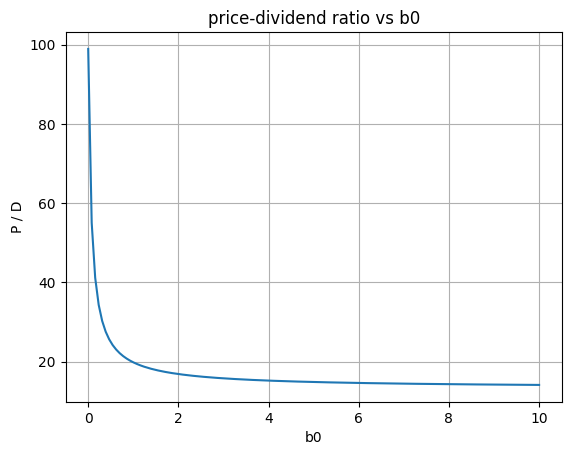

In [29]:
plt.plot(df['b0'], df['P/D'])
plt.xlabel('b0')
plt.ylabel('P / D')
plt.title('price-dividend ratio vs b0')
plt.grid()
plt.show()

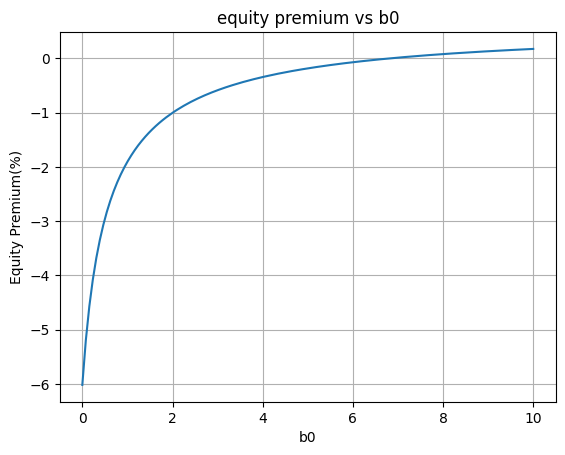

In [30]:
plt.plot(df['b0'], df['Equity Premium(%)'])
plt.xlabel('b0')
plt.ylabel('Equity Premium(%)')
plt.title('equity premium vs b0')
plt.grid()
plt.show()


Briefly explain (in words) how to extend the model to incorporate the house money effect.


answer: use a variable taking into account b0 as a function of previous gains.